# eBOSS

### Imports

In [122]:
# some_file.py
import sys
import yaml
# insert at 1, 0 is the script path (or '' in REPL)

sys.path.insert(1, '/home/jaimerz/PhD/xCell')

from xcell.mappers import MappereBOSS
from xcell.mappers import utils
from astropy.io import fits
from astropy.table import Table
import pyccl as ccl
import numpy as np
import pylab as plt
import pymaster as nmt
import healpy as hp
import numpy as np

### Configurations

In [123]:
ells = [0, 30, 60, 90, 120, 150, 180, 210, 240, 272, 309, 351, 398, 452, 513, 582, 661, 750, 852, 967, 1098, 1247, 1416, 1536] #1608, 1826, 2073, 2354, 2673, 3072]
bands = nmt.NmtBin.from_edges(ells[:-1], ells[1:])
ell_arr = bands.get_effective_ells()

In [124]:
bands = nmt.NmtBin.from_edges(ells[:-1], ells[1:])
ell_arr = bands.get_effective_ells()

In [125]:
with open("../config_files/eBOSS/map_QSO_0.yml", 'r') as stream:
    config_QSO_0 = yaml.safe_load(stream)

with open("../config_files/eBOSS/map_QSO_1.yml", 'r') as stream:
    config_QSO_1 = yaml.safe_load(stream)

with open("../config_files/eBOSS/map_ELG.yml", 'r') as stream:
    config_ELG = yaml.safe_load(stream)

with open("../config_files/eBOSS/map_LRG.yml", 'r') as stream:
    config_LRG = yaml.safe_load(stream)

### Create maps

In [126]:
QSO_0 = MappereBOSS(config_QSO_0)
QSO_1 = MappereBOSS(config_QSO_1)
ELG = MappereBOSS(config_ELG)
LRG = MappereBOSS(config_LRG)

In [127]:
ELG_map = ELG.get_signal_map()
LRG_map = LRG.get_signal_map()
QSO_0_map = QSO_0.get_signal_map()
QSO_1_map =QSO_1.get_signal_map()

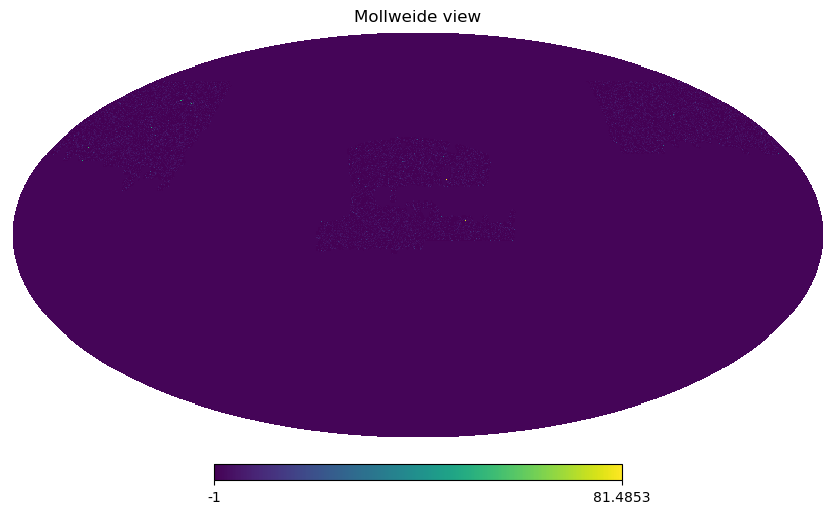

In [128]:
hp.visufunc.mollview(map=np.array(QSO_0_map)[0])

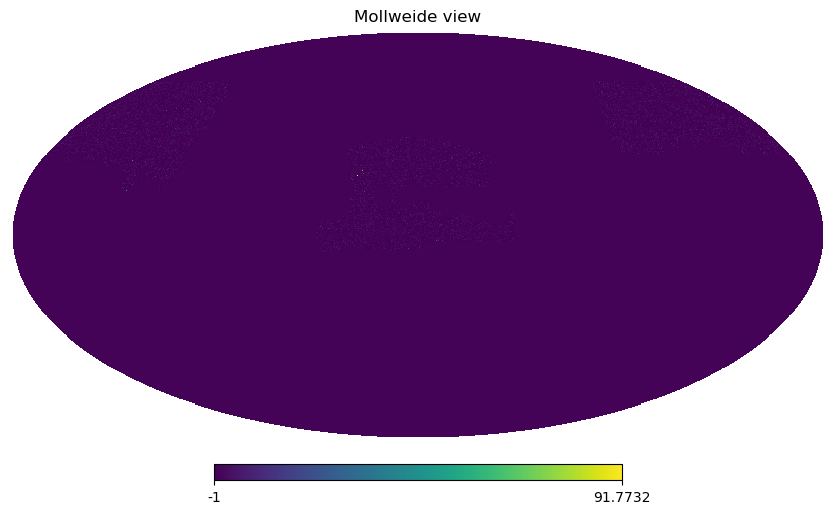

In [129]:
hp.visufunc.mollview(map=np.array(QSO_1_map)[0])

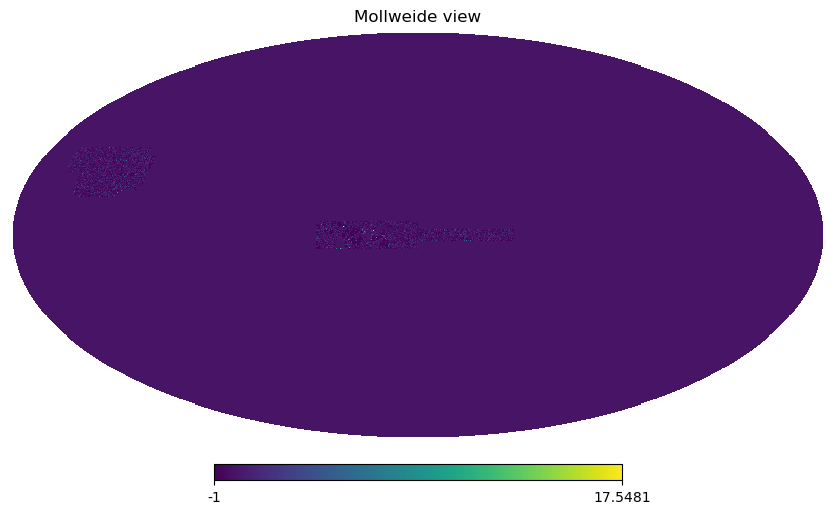

In [130]:
hp.visufunc.mollview(map=np.array(ELG_map)[0])

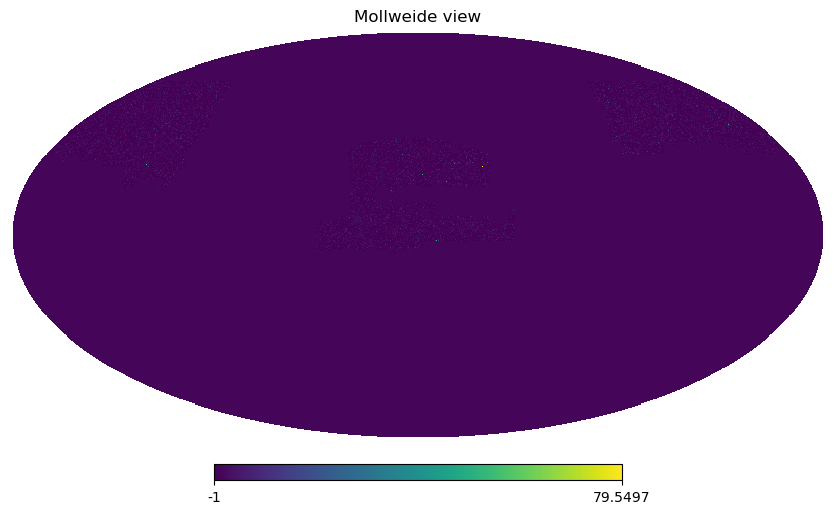

In [131]:
hp.visufunc.mollview(map=np.array(LRG_map)[0])

### Cl's

In [135]:
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.049, h=0.67, sigma8=0.81, n_s=0.96)
#ELG: 𝑏SGC = 1.310 ± 0.020 , 𝑏NGC = 1.330 ± 0.020 https://arxiv.org/pdf/2007.09012.pdf
b_QSO_0 = config_QSO_0["bias"]*np.ones(config_QSO_0["num_z_bins"])
b_QSO_1 = config_QSO_1["bias"]*np.ones(config_QSO_1["num_z_bins"]) 
b_ELG = config_ELG["bias"]*np.ones(config_ELG["num_z_bins"]) # https://arxiv.org/abs/1509.05045
b_LRG = config_LRG["bias"]*np.ones(config_LRG["num_z_bins"]) # https://arxiv.org/pdf/1607.05383.pdf

In [136]:
QSO_0_nz = QSO_0.get_nz()
QSO_1_nz = QSO_1.get_nz()
LRG_nz = LRG.get_nz()
ELG_nz = ELG.get_nz()

QSO_0_z = QSO_0_nz[0]
QSO_0_dNdz = QSO_0_nz[1]
QSO_1_z = QSO_1_nz[0]
QSO_1_dNdz = QSO_1_nz[1]
LRG_z = LRG_nz[0]
LRG_dNdz = LRG_nz[1]
ELG_z = ELG_nz[0]
ELG_dNdz = ELG_nz[1]

In [137]:
QSOt_0 = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(QSO_0_z, QSO_0_dNdz), bias=(QSO_0_z, b_QSO_0))
QSOt_1 = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(QSO_1_z, QSO_1_dNdz), bias=(QSO_1_z, b_QSO_1))
ELGt = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(ELG_z, ELG_dNdz), bias=(ELG_z, b_ELG))
LRGt = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(LRG_z, LRG_dNdz), bias=(LRG_z, b_LRG))

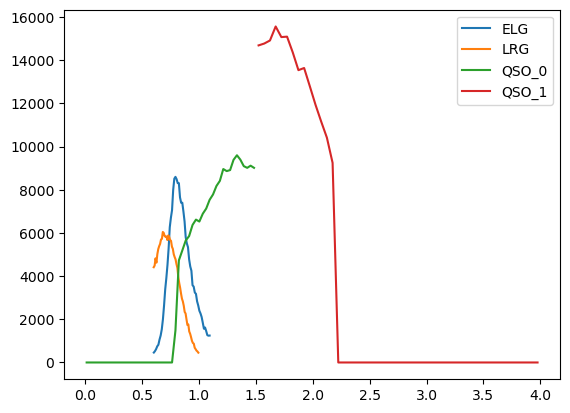

In [138]:
plt.plot(ELG_z, ELG_dNdz, label='ELG')
plt.plot(LRG_z, LRG_dNdz, label='LRG')
plt.plot(QSO_0_z, QSO_0_dNdz, label='QSO_0')
plt.plot(QSO_1_z, QSO_1_dNdz, label='QSO_1')
plt.legend()
plt.show()

In [139]:
QSOt_cl_00 = ccl.angular_cl(cosmo, QSOt_0, QSOt_0, ell_arr) 
QSOt_cl_11 = ccl.angular_cl(cosmo, QSOt_1, QSOt_1, ell_arr) 
ELGt_cl = ccl.angular_cl(cosmo, ELGt, ELGt, ell_arr) 
LRGt_cl = ccl.angular_cl(cosmo, LRGt, LRGt, ell_arr) 

In [140]:
QSO_f_0 =  QSO_0.get_nmt_field()
QSO_f_1 =  QSO_1.get_nmt_field()

In [141]:
ELG_f =  ELG.get_nmt_field()
LRG_f =  LRG.get_nmt_field()

In [142]:
QSO_w_00 = nmt.NmtWorkspace()
QSO_w_00.compute_coupling_matrix(QSO_f_0, QSO_f_0, bands)

QSO_w_11 = nmt.NmtWorkspace()
QSO_w_11.compute_coupling_matrix(QSO_f_1, QSO_f_1, bands)

In [143]:
ELG_w = nmt.NmtWorkspace()
ELG_w.compute_coupling_matrix(ELG_f, ELG_f, bands)

LRG_w = nmt.NmtWorkspace()
LRG_w.compute_coupling_matrix(LRG_f, LRG_f, bands)

In [144]:
QSO_cl_c_00 = nmt.compute_coupled_cell(QSO_f_0, QSO_f_0)
QSO_cl_c_11 = nmt.compute_coupled_cell(QSO_f_1, QSO_f_1)
ELG_cl_c = nmt.compute_coupled_cell(ELG_f, ELG_f)
LRG_cl_c = nmt.compute_coupled_cell(LRG_f, LRG_f)

In [145]:
QSO_cl_00 = QSO_w_00.decouple_cell(QSO_cl_c_00)
QSO_cl_11 = QSO_w_11.decouple_cell(QSO_cl_c_11)
ELG_cl = ELG_w.decouple_cell(ELG_cl_c)
LRG_cl = LRG_w.decouple_cell(LRG_cl_c)

In [146]:
QSO_nl_c_00 = QSO_0.get_nl_coupled() 
QSO_nl_c_11 = QSO_1.get_nl_coupled() 
ELG_nl_c = ELG.get_nl_coupled() 
LRG_nl_c = LRG.get_nl_coupled() 

calculing nl from weights
calculing nl from weights
calculing nl from weights
calculing nl from weights


In [147]:
QSO_nl_00 = QSO_w_00.decouple_cell(QSO_nl_c_00)
QSO_nl_11 = QSO_w_11.decouple_cell(QSO_nl_c_11)
ELG_nl = ELG_w.decouple_cell(ELG_nl_c)
LRG_nl = LRG_w.decouple_cell(LRG_nl_c)

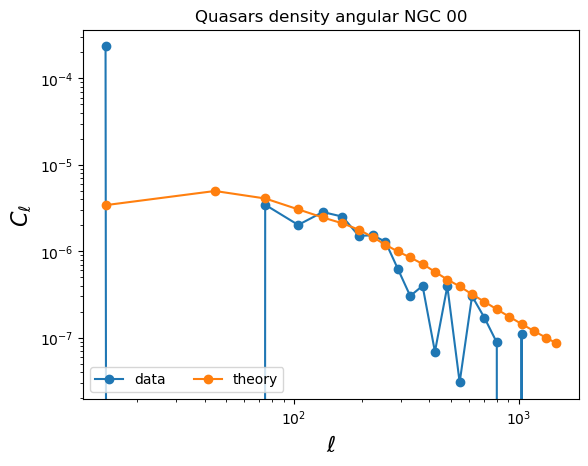

In [148]:
plt.plot(ell_arr, QSO_cl_00[0]-QSO_nl_00[0], 'o-', label='data')
plt.plot(ell_arr, QSOt_cl_00, 'o-', label='theory')
plt.title('Quasars density angular NGC 00')
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.xscale("log")
plt.yscale("log")
plt.show()

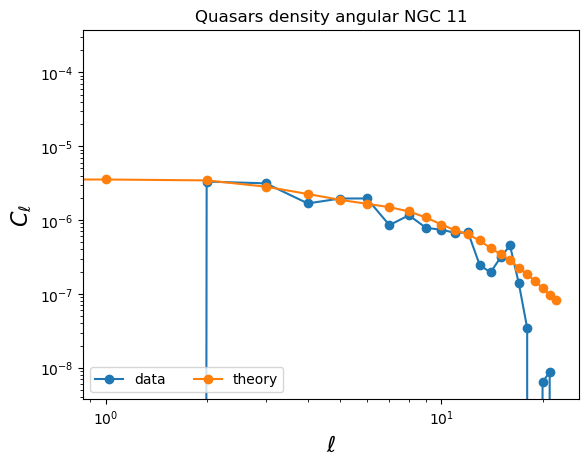

In [149]:
plt.plot(QSO_cl_11[0]-QSO_nl_11[0], 'o-', label='data')
plt.plot(QSOt_cl_11, 'o-', label='theory')
plt.title('Quasars density angular NGC 11')
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.xscale("log")
plt.yscale("log")
plt.show()

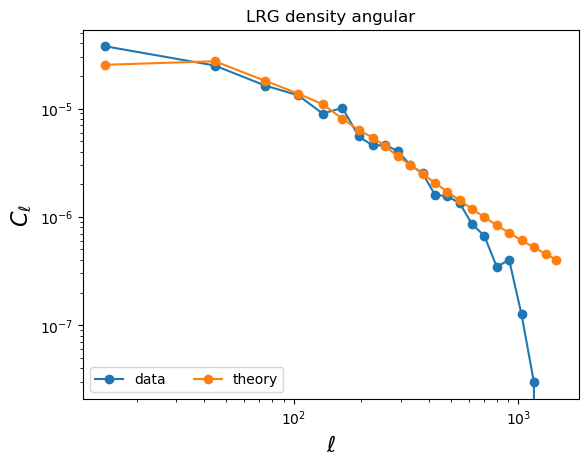

In [150]:
plt.plot(ell_arr, LRG_cl[0]-LRG_nl[0], 'o-', label='data')
plt.plot(ell_arr, LRGt_cl, 'o-', label='theory')
plt.title('LRG density angular')
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.xscale('log')
plt.yscale('log')
plt.show()

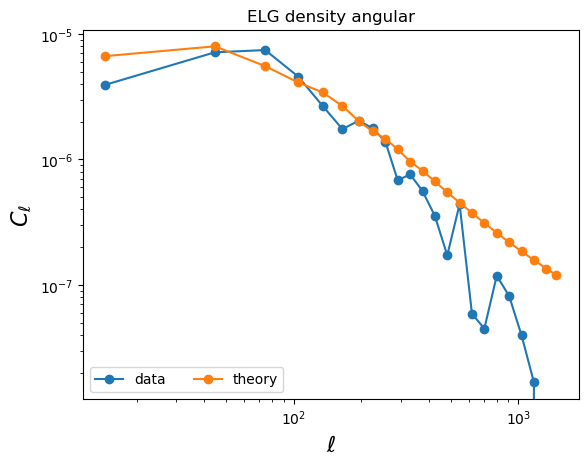

In [151]:
plt.plot(ell_arr, ELG_cl[0]-ELG_nl[0], 'o-', label='data')
plt.plot(ell_arr, ELGt_cl, 'o-', label='theory')
plt.title('ELG density angular')
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.xscale('log')
plt.yscale('log')
plt.show()